In [9]:
# Adjust your path for the data imports
path = "/Users/joche/Documents/GitHub/GVAR_modeling/"

In [3]:
# Imports
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from matplotlib.ticker import FuncFormatter

# Smoothing spline model

In [4]:
def get_natural_cubic_spline_model(x, y, minval=None, maxval=None, n_knots=None, knots=None):
    """
    Get a natural cubic spline model for the data.

    For the knots, give (a) `knots` (as an array) or (b) minval, maxval and n_knots.

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.

    Parameters
    ----------
    x: np.array of float
        The input data
    y: np.array of float
        The outpur data
    minval: float 
        Minimum of interval containing the knots.
    maxval: float 
        Maximum of the interval containing the knots.
    n_knots: positive integer 
        The number of knots to create.
    knots: array or list of floats 
        The knots.

    Returns
    --------
    model: a model object
        The returned model will have following method:
        - predict(x):
            x is a numpy array. This will return the predicted y-values.
    """

    if knots:
        spline = NaturalCubicSpline(knots=knots)
    else:
        spline = NaturalCubicSpline(max=maxval, min=minval, n_knots=n_knots)

    p = Pipeline([
        ('nat_cubic', spline),
        ('regression', LinearRegression(fit_intercept=True))
    ])

    p.fit(x, y)

    return p


class AbstractSpline(BaseEstimator, TransformerMixin):
    """Base class for all spline basis expansions."""

    def __init__(self, max=None, min=None, n_knots=None, n_params=None, knots=None):
        if knots is None:
            if not n_knots:
                n_knots = self._compute_n_knots(n_params)
            knots = np.linspace(min, max, num=(n_knots + 2))[1:-1]
            max, min = np.max(knots), np.min(knots)
        self.knots = np.asarray(knots)

    @property
    def n_knots(self):
        return len(self.knots)

    def fit(self, *args, **kwargs):
        return self


class NaturalCubicSpline(AbstractSpline):
    """Apply a natural cubic basis expansion to an array.
    The features created with this basis expansion can be used to fit a
    piecewise cubic function under the constraint that the fitted curve is
    linear *outside* the range of the knots..  The fitted curve is continuously
    differentiable to the second order at all of the knots.
    This transformer can be created in two ways:
      - By specifying the maximum, minimum, and number of knots.
      - By specifying the cutpoints directly.  

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.
    Parameters
    ----------
    min: float 
        Minimum of interval containing the knots.
    max: float 
        Maximum of the interval containing the knots.
    n_knots: positive integer 
        The number of knots to create.
    knots: array or list of floats 
        The knots.
    """

    def _compute_n_knots(self, n_params):
        return n_params

    @property
    def n_params(self):
        return self.n_knots - 1

    def transform(self, X, **transform_params):
        X_spl = self._transform_array(X)
        if isinstance(X, pd.Series):
            col_names = self._make_names(X)
            X_spl = pd.DataFrame(X_spl, columns=col_names, index=X.index)
        return X_spl

    def _make_names(self, X):
        first_name = "{}_spline_linear".format(X.name)
        rest_names = ["{}_spline_{}".format(X.name, idx)
                      for idx in range(self.n_knots - 2)]
        return [first_name] + rest_names

    def _transform_array(self, X, **transform_params):
        X = X.squeeze()
        try:
            X_spl = np.zeros((X.shape[0], self.n_knots - 1))
        except IndexError: # For arrays with only one element
            X_spl = np.zeros((1, self.n_knots - 1))
        X_spl[:, 0] = X.squeeze()

        def d(knot_idx, x):
            def ppart(t): return np.maximum(0, t)

            def cube(t): return t*t*t
            numerator = (cube(ppart(x - self.knots[knot_idx]))
                         - cube(ppart(x - self.knots[self.n_knots - 1])))
            denominator = self.knots[self.n_knots - 1] - self.knots[knot_idx]
            return numerator / denominator

        for i in range(0, self.n_knots - 2):
            X_spl[:, i+1] = (d(i, X) - d(self.n_knots - 2, X)).squeeze()
        return X_spl
    
    """
    I used this piece of code from Nico Pasanen
    This could be found on https://stackoverflow.com/questions/51321100/python-natural-smoothing-splines
    """

In [17]:
def quarterly_to_monthly(quarterly_data):
    """
    This function turns the quarterly data from Q1 1996 until Q4 2022
    """
    quarterly_time = np.linspace(1996.125,2022.875,108)
    monthly_time = np.linspace(1996.041666666,2022.958333333,324)
    model = get_natural_cubic_spline_model(quarterly_time, quarterly_data, minval=1996, maxval=2023, n_knots=108)
    return model.predict(monthly_time)

# Import data

In [25]:
# Import all dataframes
variable_list = ['GDP_quarterly','CPI_quarterly','CPI_monthly']
df = pd.read_excel(path+"Interpolation_data.xlsx",index_col=0, sheet_name=variable_list)

# Save the monthly time
monthly_time = df['CPI_monthly'].columns

# Example

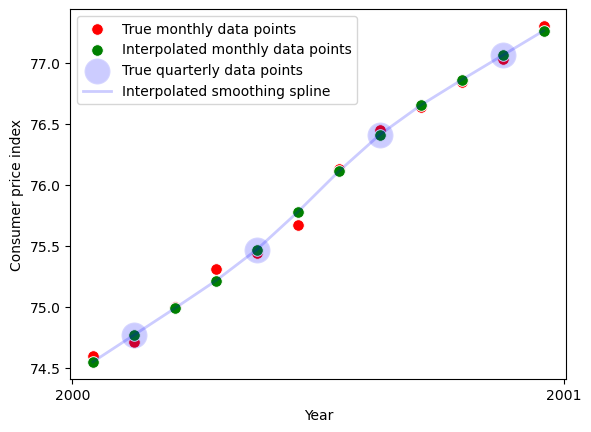

In [31]:
# Get the monthly data of CPI
df_cpi_monthly = df['CPI_monthly']
df_cpi_quarterly = df['CPI_quarterly']

# Define the number of years and country
years = 1
country = "Spain"

# Get two sample from the year 2000 until 2000 + years
cpi_monthly_example = df_cpi_monthly.iloc[:,4*12:4*12+years*12].loc[country].to_numpy()
cpi_quarterly_example = df_cpi_quarterly.iloc[:,4*4:4*4+years*4].loc[country].to_numpy()

# Define the monthly and quarterly time points based on the amount of years
monthly_time_example = np.linspace(2000.041666666,2000.958333333+years-1,years*12)
quarterly_time_example = np.linspace(2000.125,2000.875+years-1,years*4)

# Fit the model and predict the monthly CPI
model_example = get_natural_cubic_spline_model(quarterly_time_example, cpi_quarterly_example, minval=2000, maxval=2000+years, n_knots=years*4)
cpi_monthly_example_sim = model_example.predict(monthly_time_example)

# Plot the all gardered data in a Figure
plt.xticks([1990,1991,1992,1993,2000,2001,2002])
sns.scatterplot(x=monthly_time_example,y=cpi_monthly_example,color='r',s=70)
sns.scatterplot(x=monthly_time_example,y=cpi_monthly_example_sim,color='g',s=70)
sns.scatterplot(x=quarterly_time_example,y=cpi_quarterly_example,s =350,color='b',alpha=0.2) 
sns.lineplot(x=monthly_time_example,y=cpi_monthly_example_sim,color='b',alpha=0.2,linewidth=2)
plt.legend(labels=['True monthly data points','Interpolated monthly data points','True quarterly data points','Interpolated smoothing spline'])
plt.ylabel('Consumer price index')
plt.xlabel('Year')
plt.show()

# GDP

Transform all quarterly GDP data to monthly

In [19]:
# Get and show the GDP quarterly data
df_gdp = df['GDP_quarterly']
df_gdp

,Q1 1996,Q2 1996,Q3 1996,Q4 1996,Q1 1997,Q2 1997,Q3 1997,Q4 1997,Q1 1998,Q2 1998,...,Q3 2020,Q4 2020,Q1 2021,Q2 2021,Q3 2021,Q4 2021,Q1 2022,Q2 2022,Q3 2022,Q4 2022
Australia,2.529880e+05,2.545990e+05,2.566340e+05,2.590250e+05,2.606560e+05,2.684360e+05,2.687790e+05,2.726890e+05,2.744620e+05,2.770180e+05,...,5.015680e+05,5.177090e+05,5.285590e+05,5.325830e+05,5.221680e+05,5.412730e+05,5.443640e+05,5.492740e+05,5.530360e+05,5.556900e+05
Brazil,1.755120e+05,1.775105e+05,1.841215e+05,1.823543e+05,1.842610e+05,1.852617e+05,1.875799e+05,1.891449e+05,1.854236e+05,1.885463e+05,...,2.922289e+05,3.020781e+05,3.052471e+05,3.043214e+05,3.052672e+05,3.085062e+05,3.126191e+05,3.154392e+05,3.163165e+05,3.156174e+05
Canada,2.985095e+05,3.005880e+05,3.031850e+05,3.056268e+05,3.096585e+05,3.131565e+05,3.168625e+05,3.199308e+05,3.244495e+05,3.246228e+05,...,5.047170e+05,5.154700e+05,5.222170e+05,5.191433e+05,5.265715e+05,5.353735e+05,5.385443e+05,5.432930e+05,5.464230e+05,5.464775e+05
France,3.852178e+05,3.856383e+05,3.876093e+05,3.886102e+05,3.899615e+05,3.938755e+05,3.977259e+05,4.016592e+05,4.054173e+05,4.086860e+05,...,5.447861e+05,5.398242e+05,5.404950e+05,5.458103e+05,5.638488e+05,5.672912e+05,5.659386e+05,5.689822e+05,5.695027e+05,5.696429e+05
Germany,5.336460e+05,5.408254e+05,5.426377e+05,5.467502e+05,5.438924e+05,5.509324e+05,5.526052e+05,5.567874e+05,5.620151e+05,5.595755e+05,...,7.290412e+05,7.335719e+05,7.228028e+05,7.367431e+05,7.425282e+05,7.423192e+05,7.499169e+05,7.490108e+05,7.525656e+05,7.485229e+05
Italy,3.574301e+05,3.569662e+05,3.574066e+05,3.562154e+05,3.574799e+05,3.622983e+05,3.648050e+05,3.713639e+05,3.685563e+05,3.707106e+05,...,3.827732e+05,3.801357e+05,3.819219e+05,3.913309e+05,4.026378e+05,4.062964e+05,4.068390e+05,4.111335e+05,4.126361e+05,4.121196e+05
Japan,1.166515e+08,1.181397e+08,1.182911e+08,1.196014e+08,1.199155e+08,1.190195e+08,1.192538e+08,1.192884e+08,1.178443e+08,1.173258e+08,...,1.323630e+08,1.348523e+08,1.346184e+08,1.350494e+08,1.346184e+08,1.361684e+08,1.355046e+08,1.370626e+08,1.367212e+08,1.367035e+08
Korea,1.793627e+08,1.829861e+08,1.862047e+08,1.893545e+08,1.902408e+08,1.969954e+08,1.985551e+08,1.976497e+08,1.841739e+08,1.826859e+08,...,4.602540e+08,4.658403e+08,4.738717e+08,4.778207e+08,4.788396e+08,4.852454e+08,4.883217e+08,4.919317e+08,4.935198e+08,4.915172e+08
New Zealand,3.261400e+04,3.303900e+04,3.343700e+04,3.357500e+04,3.336900e+04,3.420400e+04,3.485200e+04,3.428800e+04,3.425000e+04,3.409000e+04,...,6.750600e+04,6.756600e+04,6.855800e+04,7.025400e+04,6.706300e+04,6.916700e+04,6.874000e+04,7.004000e+04,7.139900e+04,7.086300e+04
South Africa,6.313439e+05,6.388655e+05,6.464775e+05,6.525425e+05,6.555718e+05,6.596849e+05,6.603408e+05,6.604320e+05,6.621670e+05,6.631035e+05,...,1.082480e+06,1.111674e+06,1.120823e+06,1.136379e+06,1.115905e+06,1.131186e+06,1.149192e+06,1.140048e+06,1.160793e+06,1.146250e+06


In [27]:
# Select all countries that need interpolation
countries = df_gdp.index

# Initialize array for country information
country_collection = []

# Loop over all selected countries and save this monthly data
for country in countries:
    gdp_country = df_gdp.loc[country].values
    gdp_monthly = np.round(quarterly_to_monthly(gdp_country), decimals=2)
    country_collection.append(gdp_monthly)

# Make a dataframe of all information
df_gdp_monthly = pd.DataFrame(country_collection,index=countries,columns=monthly_time)

# You can potentially save this dataframe into an excel sheet
# df_gdp_monthly.to_excel(path + "saved_values.xlsx")

df_gdp_monthly

,1996-01-01,1996-02-01,1996-03-01,1996-04-01,1996-05-01,1996-06-01,1996-07-01,1996-08-01,1996-09-01,1996-10-01,...,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
Australia,2.524574e+05,2.529880e+05,2.535186e+05,2.540499e+05,2.545990e+05,2.551977e+05,2.558768e+05,2.566340e+05,2.574387e+05,2.582574e+05,...,5.459636e+05,5.476587e+05,5.492740e+05,5.507389e+05,5.519916e+05,5.530360e+05,5.539519e+05,5.548220e+05,5.556900e+05,5.565580e+05
Brazil,1.749263e+05,1.755120e+05,1.760977e+05,1.766934e+05,1.775105e+05,1.789482e+05,1.813588e+05,1.841215e+05,1.857728e+05,1.849501e+05,...,3.136822e+05,3.146278e+05,3.154392e+05,3.160325e+05,3.163226e+05,3.163165e+05,3.161279e+05,3.158741e+05,3.156174e+05,3.153607e+05
Canada,2.978251e+05,2.985095e+05,2.991939e+05,2.998793e+05,3.005880e+05,3.013620e+05,3.022399e+05,3.031850e+05,3.040953e+05,3.048782e+05,...,5.398974e+05,5.415227e+05,5.432930e+05,5.448790e+05,5.459472e+05,5.464230e+05,5.465307e+05,5.465071e+05,5.464775e+05,5.464479e+05
France,3.851032e+05,3.852178e+05,3.853324e+05,3.854502e+05,3.856383e+05,3.860232e+05,3.867209e+05,3.876093e+05,3.883607e+05,3.886653e+05,...,5.672126e+05,5.683428e+05,5.689822e+05,5.692811e+05,5.694189e+05,5.695027e+05,5.695567e+05,5.696001e+05,5.696429e+05,5.696858e+05
Germany,5.311650e+05,5.336460e+05,5.361269e+05,5.385970e+05,5.408254e+05,5.423764e+05,5.428506e+05,5.426377e+05,5.428113e+05,5.443704e+05,...,7.479442e+05,7.473810e+05,7.490108e+05,7.513267e+05,7.527125e+05,7.525656e+05,7.514529e+05,7.499956e+05,7.485229e+05,7.470502e+05
Italy,3.576006e+05,3.574301e+05,3.572597e+05,3.570912e+05,3.569662e+05,3.569634e+05,3.571518e+05,3.574066e+05,3.574350e+05,3.569684e+05,...,4.083480e+05,4.098802e+05,4.111335e+05,4.120334e+05,4.125221e+05,4.126361e+05,4.125199e+05,4.123216e+05,4.121196e+05,4.119177e+05
Japan,1.161331e+08,1.166515e+08,1.171699e+08,1.176855e+08,1.181397e+08,1.184219e+08,1.184319e+08,1.182911e+08,1.183134e+08,1.187927e+08,...,1.363363e+08,1.369284e+08,1.370626e+08,1.369421e+08,1.367921e+08,1.367212e+08,1.367026e+08,1.367026e+08,1.367035e+08,1.367044e+08
Korea,1.781484e+08,1.793627e+08,1.805770e+08,1.817905e+08,1.829861e+08,1.841314e+08,1.851966e+08,1.862047e+08,1.872250e+08,1.883167e+08,...,4.893133e+08,4.905454e+08,4.919317e+08,4.930959e+08,4.936535e+08,4.935198e+08,4.929567e+08,4.922404e+08,4.915172e+08,4.907940e+08
New Zealand,3.247209e+04,3.261400e+04,3.275591e+04,3.289778e+04,3.303900e+04,3.317836e+04,3.331422e+04,3.343700e+04,3.353027e+04,3.357805e+04,...,6.883743e+04,6.928918e+04,7.004000e+04,7.080409e+04,7.128791e+04,7.139900e+04,7.127702e+04,7.107188e+04,7.086300e+04,7.065412e+04
South Africa,6.288392e+05,6.313439e+05,6.338486e+05,6.363535e+05,6.388655e+05,6.413971e+05,6.439570e+05,6.464775e+05,6.488247e+05,6.508668e+05,...,1.136508e+06,1.132308e+06,1.140048e+06,1.152024e+06,1.160000e+06,1.160793e+06,1.157049e+06,1.151686e+06,1.146250e+06,1.140814e+06


# CPI

Transform quarterly CPI from Australia and New Zealand to monthly CPI:

In [21]:
# Get and show the CPI quarterly data
df_cpi = df['CPI_quarterly']
df_cpi

,Q1 1996,Q2 1996,Q3 1996,Q4 1996,Q1 1997,Q2 1997,Q3 1997,Q4 1997,Q1 1998,Q2 1998,...,Q3 2020,Q4 2020,Q1 2021,Q2 2021,Q3 2021,Q4 2021,Q1 2022,Q2 2022,Q3 2022,Q4 2022
Australia,68.89,69.41,69.61,69.72,69.82,69.61,69.30,69.51,69.72,70.14,...,120.92,121.96,122.68,123.62,124.56,126.22,128.93,131.22,133.61,136.11
Brazil,40.81,42.07,43.19,43.59,44.51,45.33,45.66,45.90,46.58,47.03,...,172.25,176.44,180.57,184.10,188.85,194.94,199.97,206.04,205.18,206.73
Canada,75.73,76.33,76.45,76.90,77.33,77.56,77.76,77.70,78.13,78.33,...,117.66,118.09,119.26,120.98,122.44,123.67,126.22,130.11,131.20,131.91
France,80.59,81.21,81.03,81.36,81.76,81.96,82.07,82.30,82.37,82.77,...,110.80,110.58,111.21,112.06,112.71,113.58,115.28,117.98,119.30,120.47
Germany,81.34,81.61,81.81,81.84,82.77,82.87,83.71,83.57,83.81,84.01,...,112.68,112.79,114.79,115.99,117.05,118.10,120.29,123.72,125.71,128.24
Italy,73.63,74.44,74.63,74.99,75.46,75.85,75.99,76.47,76.99,77.40,...,110.40,110.22,111.26,111.98,112.80,114.13,117.57,119.72,122.26,127.53
Japan,100.74,101.47,101.29,101.57,101.33,103.54,103.51,103.78,103.37,103.89,...,105.47,104.97,105.29,104.76,105.29,105.50,106.20,107.26,108.31,109.58
Korea,62.00,63.02,63.68,63.94,64.91,65.57,66.21,67.18,70.71,70.93,...,115.99,116.01,117.50,118.12,118.93,120.12,121.97,124.51,125.92,126.43
New Zealand,72.56,73.11,73.52,74.06,73.86,73.93,74.27,74.68,74.81,75.16,...,116.31,116.86,117.85,119.40,122.05,123.81,126.02,128.12,130.88,132.75
South Africa,45.10,46.00,47.06,48.16,49.43,50.31,51.11,51.47,52.15,52.89,...,165.02,165.96,167.83,170.41,173.17,174.99,177.63,181.79,186.89,188.42


In [26]:
# Select all countries that need interpolation
countries = ['Australia','New Zealand']

# Initialize array for country information
country_collection = []

# Loop over all selected countries and save this monthly data
for country in countries:
    cpi_country = df_cpi.loc[country].values
    cpi_monthly = np.round(quarterly_to_monthly(cpi_country), decimals=2)
    country_collection.append(cpi_monthly)

# Make a dataframe of all information
df_cpi_monthly = pd.DataFrame(country_collection,index=countries,columns=monthly_time)

# You can potentially save this dataframe into an excel sheet
# df_cpi_monthly.to_excel(path + "saved_values.xlsx")

df_cpi_monthly

,1996-01-01,1996-02-01,1996-03-01,1996-04-01,1996-05-01,1996-06-01,1996-07-01,1996-08-01,1996-09-01,1996-10-01,...,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
Australia,68.71,68.89,69.07,69.25,69.41,69.54,69.6,69.61,69.61,69.65,...,129.70,130.46,131.22,132.00,132.79,133.61,134.44,135.28,136.11,136.94
New Zealand,72.37,72.56,72.75,72.93,73.11,73.27,73.4,73.52,73.66,73.85,...,126.48,127.16,128.12,129.17,130.12,130.88,131.53,132.14,132.75,133.36
